In [1]:
#Creating Patches for Mariposa images -> See Galice.ipynb for detailed comments

import os
import cv2
import numpy as np
from tqdm import tqdm


original_img_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\01.1.jpg'
mask_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\ground_truth11.tif'  


out_img_dir = 'dataset11/images/'
out_mask_dir = 'dataset11/masks/'

os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_mask_dir, exist_ok=True)


patch_size = 256
stride = 256  

img = cv2.imread(original_img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

if img.shape[:2] != mask.shape:
    print("Image and mask shape mismatch — resizing needed")
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)


count = 0
h, w = img.shape[:2]

for y in tqdm(range(0, h - patch_size + 1, stride), desc="Slicing rows"):
    for x in range(0, w - patch_size + 1, stride):
        patch_img = img[y:y+patch_size, x:x+patch_size]
        patch_mask = mask[y:y+patch_size, x:x+patch_size]

        img_name = f'img_{count:04d}.png'
        cv2.imwrite(os.path.join(out_img_dir, img_name), patch_img)
        cv2.imwrite(os.path.join(out_mask_dir, img_name), patch_mask)

        count += 1

print(f"Saved {count} patches to dataset/images/ and dataset/masks/")

Slicing rows: 100%|██████████| 5/5 [00:00<00:00, 24.19it/s]

Saved 35 patches to dataset/images/ and dataset/masks/


In [1]:
#Loading the data

import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


IMG_SIZE = 256
NUM_CLASSES = 3

def load_data(image_dir, mask_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    X = []
    Y = []

    for img_name, mask_name in zip(image_files, mask_files):
      
        img = cv2.imread(os.path.join(image_dir, img_name))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img / 255.0)  

     
        mask = cv2.imread(os.path.join(mask_dir, mask_name), 0)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

       
        class_0 = (mask < 64)             # black → class 0
        class_1 = (mask >= 64) & (mask < 192)  # gray → class 1
        class_2 = (mask >= 192)           # white → class 2

        class_mask = np.zeros_like(mask, dtype=np.uint8)
        class_mask[class_1] = 1
        class_mask[class_2] = 2

        
        Y.append(to_categorical(class_mask, num_classes=NUM_CLASSES))

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.uint8)


X, Y = load_data('dataset11/images/', 'dataset11/masks/')
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Data ready:")
print("X:", X.shape)
print("Y:", Y.shape)


Data ready:
X: (35, 256, 256, 3)
Y: (35, 256, 256, 3)


Loading the model created in the GALICE.ipynb file 

In [4]:
#Loading the model created in the GALICE.ipynb file 
from tensorflow.keras.models import load_model

model = load_model("unet_1.h5", compile=False)


In [6]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Training the existing model using this image

Epoch 1/20
3/3 [==============================] - 5s 2s/step - loss: 0.2329 - accuracy: 0.9089 - val_loss: 0.2718 - val_accuracy: 0.8814
Epoch 2/20
3/3 [==============================] - 5s 2s/step - loss: 0.2501 - accuracy: 0.8925 - val_loss: 0.1783 - val_accuracy: 0.9233
Epoch 3/20
3/3 [==============================] - 4s 1s/step - loss: 0.1631 - accuracy: 0.9341 - val_loss: 0.1666 - val_accuracy: 0.9446
Epoch 4/20
3/3 [==============================] - 5s 2s/step - loss: 0.1623 - accuracy: 0.9440 - val_loss: 0.1937 - val_accuracy: 0.9272
Epoch 5/20
3/3 [==============================] - 5s 1s/step - loss: 0.1670 - accuracy: 0.9378 - val_loss: 0.1696 - val_accuracy: 0.9345
Epoch 6/20
3/3 [==============================] - 5s 2s/step - loss: 0.1419 - accuracy: 0.9444 - val_loss: 0.1484 - val_accuracy: 0.9426
Epoch 7/20
3/3 [==============================] - 5s 2s/step - loss: 0.1338 - accuracy: 0.9469 - val_loss: 0.1483 - val_accuracy: 0.9435
Epoch 8/20
3/3 [=========================

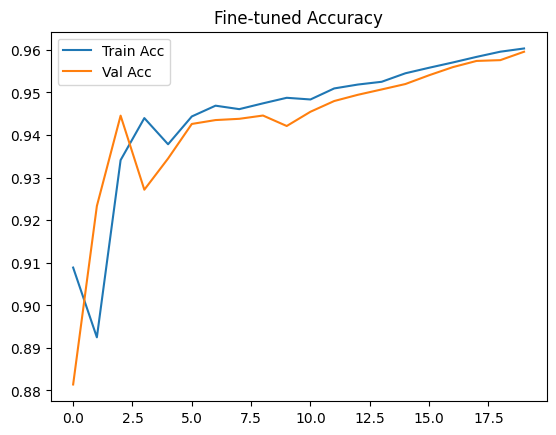

In [8]:
#Training the existing model using this image

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=8,
    callbacks=[
        ModelCheckpoint('unet_1_finetuned.h5', save_best_only=True),
        EarlyStopping(patience=5, restore_best_weights=True)
    ]
)
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Fine-tuned Accuracy")
plt.legend()
plt.show()


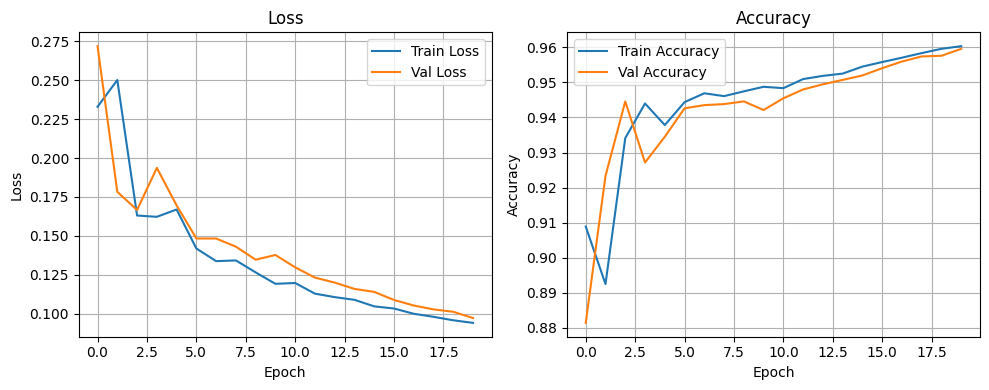

NameError: name 'pred_probs' is not defined

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
X_val


In [10]:
pred_probs = model.predict(X_val)

pred_classes = np.argmax(pred_probs, axis=-1)
true_classes = np.argmax(Y_val, axis=-1)

1/1 [==============================] - 1s 668ms/step


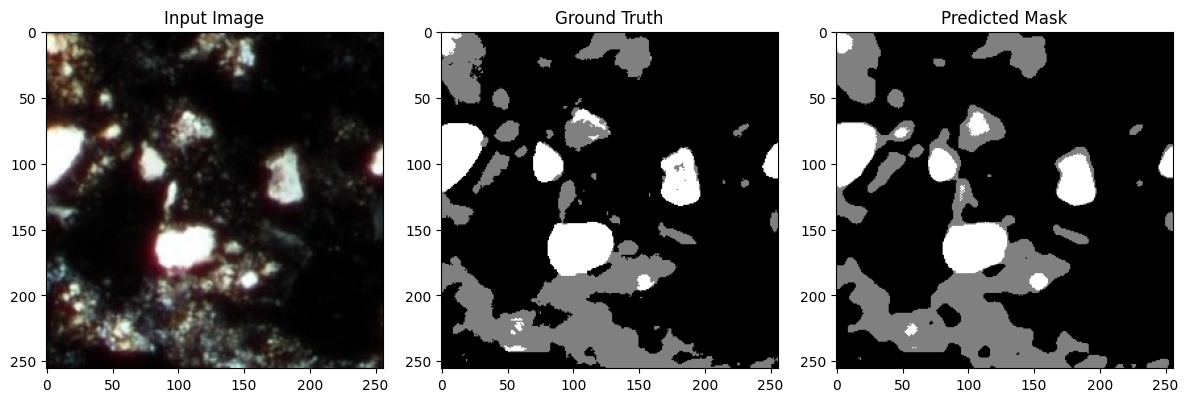

In [11]:
import matplotlib.pyplot as plt

i = 0  
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X_val[i])
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(true_classes[i], cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(pred_classes[i], cmap='gray')
plt.title("Predicted Mask")

plt.tight_layout()
plt.show()

# Applying same process to train the model again using another image


In [2]:
#Applying same process to train the model again using another image

import os
import cv2
import numpy as np
from tqdm import tqdm


original_img_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\23mar01.8.jpg'
mask_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\ground_truth18.tif'  


out_img_dir = 'dataset18/images/'
out_mask_dir = 'dataset18/masks/'

os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_mask_dir, exist_ok=True)


patch_size = 256
stride = 256 


img = cv2.imread(original_img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

if img.shape[:2] != mask.shape:
    print("Image and mask shape mismatch — resizing needed")
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)


count = 0
h, w = img.shape[:2]

for y in tqdm(range(0, h - patch_size + 1, stride), desc="Slicing rows"):
    for x in range(0, w - patch_size + 1, stride):
        patch_img = img[y:y+patch_size, x:x+patch_size]
        patch_mask = mask[y:y+patch_size, x:x+patch_size]

        img_name = f'img_{count:04d}.png'
        cv2.imwrite(os.path.join(out_img_dir, img_name), patch_img)
        cv2.imwrite(os.path.join(out_mask_dir, img_name), patch_mask)

        count += 1

print(f"Saved {count} patches to dataset/images/ and dataset/masks/")

Slicing rows: 100%|██████████| 3/3 [00:00<00:00, 32.66it/s]

Saved 12 patches to dataset/images/ and dataset/masks/


In [3]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


IMG_SIZE = 256
NUM_CLASSES = 3

def load_data(image_dir, mask_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    X = []
    Y = []

    for img_name, mask_name in zip(image_files, mask_files):
        
        img = cv2.imread(os.path.join(image_dir, img_name))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img / 255.0)  

        
        mask = cv2.imread(os.path.join(mask_dir, mask_name), 0)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

      
        class_0 = (mask < 64)             # black → class 0
        class_1 = (mask >= 64) & (mask < 192)  # gray → class 1
        class_2 = (mask >= 192)           # white → class 2

        class_mask = np.zeros_like(mask, dtype=np.uint8)
        class_mask[class_1] = 1
        class_mask[class_2] = 2

       
        Y.append(to_categorical(class_mask, num_classes=NUM_CLASSES))

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.uint8)


X, Y = load_data('dataset18/images/', 'dataset18/masks/')
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Data ready:")
print("X:", X.shape)
print("Y:", Y.shape)


Data ready:
X: (12, 256, 256, 3)
Y: (12, 256, 256, 3)


In [14]:
from tensorflow.keras.models import load_model

model = load_model("unet_1_finetuned.h5", compile=False)


Retraining the model again witht his image

In [15]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Epoch 1/30
1/1 [==============================] - 6s 6s/step - loss: 3.5677 - accuracy: 0.4434 - val_loss: 3.1705 - val_accuracy: 0.3093
Epoch 2/30
1/1 [==============================] - 1s 1s/step - loss: 2.5719 - accuracy: 0.3934 - val_loss: 2.4937 - val_accuracy: 0.2961
Epoch 3/30
1/1 [==============================] - 2s 2s/step - loss: 2.0738 - accuracy: 0.3746 - val_loss: 2.0169 - val_accuracy: 0.2941
Epoch 4/30
1/1 [==============================] - 2s 2s/step - loss: 1.7068 - accuracy: 0.3707 - val_loss: 1.6865 - val_accuracy: 0.2952
Epoch 5/30
1/1 [==============================] - 2s 2s/step - loss: 1.4522 - accuracy: 0.3715 - val_loss: 1.4708 - val_accuracy: 0.2986
Epoch 6/30
1/1 [==============================] - 1s 1s/step - loss: 1.2883 - accuracy: 0.3744 - val_loss: 1.3378 - val_accuracy: 0.3034
Epoch 7/30
1/1 [==============================] - 1s 1s/step - loss: 1.1886 - accuracy: 0.3791 - val_loss: 1.2586 - val_accuracy: 0.3085
Epoch 8/30
1/1 [=========================

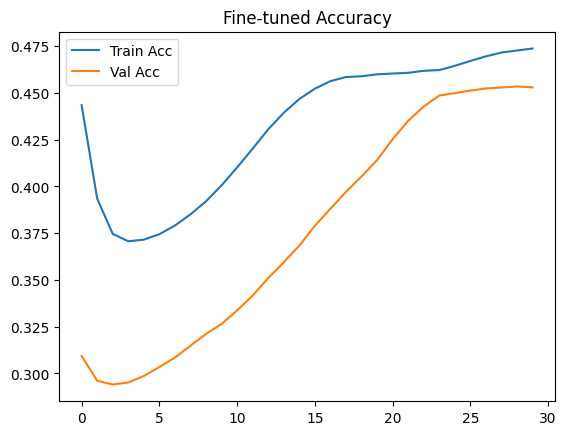

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=8,
    callbacks=[
        ModelCheckpoint('unet_1_finetuned2.h5', save_best_only=True),
        EarlyStopping(patience=5, restore_best_weights=True)
    ]
)
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Fine-tuned Accuracy")
plt.legend()
plt.show()


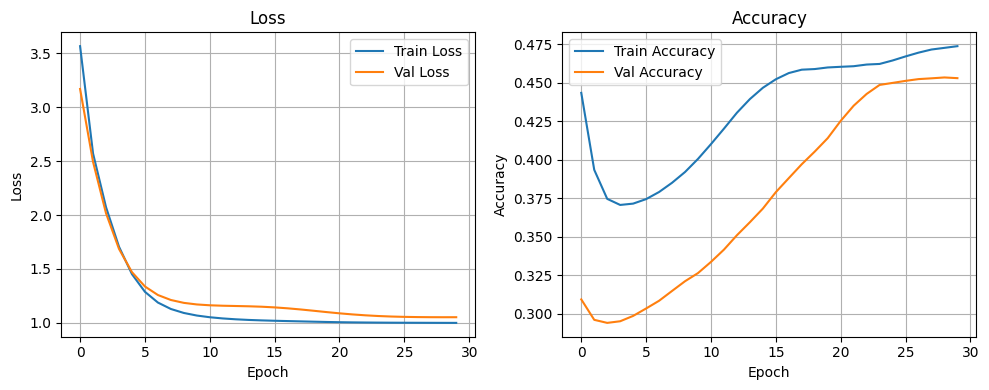

array([[[[0.2627451 , 0.10980392, 0.10196079],
         [0.2627451 , 0.10980392, 0.10196079],
         [0.2627451 , 0.10980392, 0.10196079],
         ...,
         [0.18431373, 0.12156863, 0.07450981],
         [0.18431373, 0.1254902 , 0.09019608],
         [0.13333334, 0.07058824, 0.04313726]],

        [[0.22352941, 0.07450981, 0.07450981],
         [0.23529412, 0.08627451, 0.08627451],
         [0.25490198, 0.09803922, 0.10196079],
         ...,
         [0.24313726, 0.18039216, 0.12941177],
         [0.20392157, 0.14117648, 0.09411765],
         [0.15294118, 0.09411765, 0.05882353]],

        [[0.24705882, 0.10196079, 0.10980392],
         [0.23529412, 0.09019608, 0.09803922],
         [0.24705882, 0.09411765, 0.10196079],
         ...,
         [0.31764707, 0.25882354, 0.19607843],
         [0.23529412, 0.17254902, 0.12156863],
         [0.21960784, 0.16470589, 0.11764706]],

        ...,

        [[0.4745098 , 0.41960785, 0.34901962],
         [0.4745098 , 0.41960785, 0.34901962]

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
X_val


In [18]:
pred_probs = model.predict(X_val)


pred_classes = np.argmax(pred_probs, axis=-1)
true_classes = np.argmax(Y_val, axis=-1)

1/1 [==============================] - 0s 365ms/step


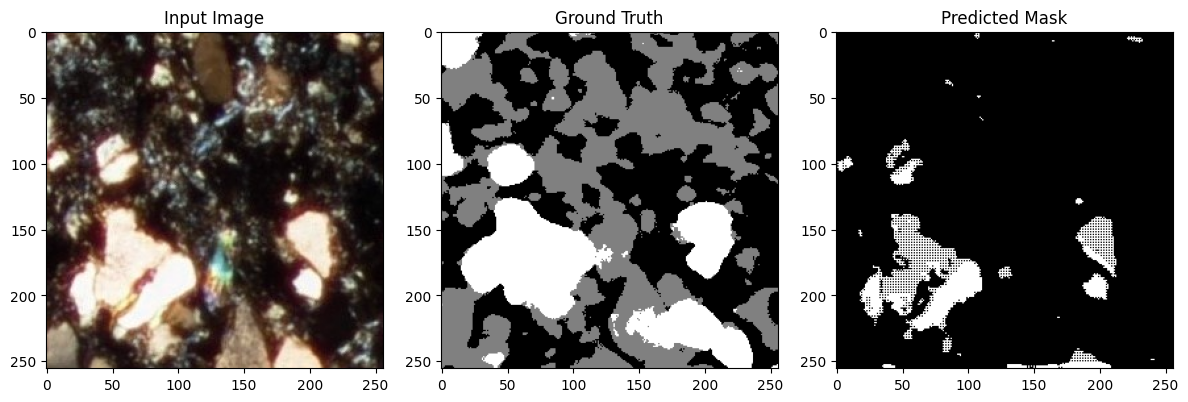

In [20]:
import matplotlib.pyplot as plt

i = 0 

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X_val[i])
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(true_classes[i], cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(pred_classes[i], cmap='gray')
plt.title("Predicted Mask")

plt.tight_layout()
plt.show()

Retraining with image 23mar01.2

In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm


original_img_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\23mar01.2.jpg'
mask_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\ground_truth12.tif'  


out_img_dir = 'dataset12/images/'
out_mask_dir = 'dataset12/masks/'

os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_mask_dir, exist_ok=True)


patch_size = 256
stride = 256 


img = cv2.imread(original_img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

if img.shape[:2] != mask.shape:
    print("Image and mask shape mismatch — resizing needed")
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)


count = 0
h, w = img.shape[:2]

for y in tqdm(range(0, h - patch_size + 1, stride), desc="Slicing rows"):
    for x in range(0, w - patch_size + 1, stride):
        patch_img = img[y:y+patch_size, x:x+patch_size]
        patch_mask = mask[y:y+patch_size, x:x+patch_size]

        img_name = f'img_{count:04d}.png'
        cv2.imwrite(os.path.join(out_img_dir, img_name), patch_img)
        cv2.imwrite(os.path.join(out_mask_dir, img_name), patch_mask)

        count += 1

print(f"Saved {count} patches to dataset/images/ and dataset/masks/")

Slicing rows: 100%|██████████| 6/6 [00:00<00:00, 14.62it/s]

Saved 48 patches to dataset/images/ and dataset/masks/


In [6]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


IMG_SIZE = 256
NUM_CLASSES = 3

def load_data(image_dir, mask_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    X = []
    Y = []

    for img_name, mask_name in zip(image_files, mask_files):
        
        img = cv2.imread(os.path.join(image_dir, img_name))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img / 255.0)  

        
        mask = cv2.imread(os.path.join(mask_dir, mask_name), 0)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

      
        class_0 = (mask < 64)             # black → class 0
        class_1 = (mask >= 64) & (mask < 192)  # gray → class 1
        class_2 = (mask >= 192)           # white → class 2

        class_mask = np.zeros_like(mask, dtype=np.uint8)
        class_mask[class_1] = 1
        class_mask[class_2] = 2

        
        Y.append(to_categorical(class_mask, num_classes=NUM_CLASSES))

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.uint8)


X, Y = load_data('dataset12/images/', 'dataset12/masks/')
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Data ready:")
print("X:", X.shape)
print("Y:", Y.shape)


Data ready:
X: (48, 256, 256, 3)
Y: (48, 256, 256, 3)


Reloading the model and trinaing with new patches

In [25]:
from tensorflow.keras.models import load_model

model = load_model("unet_1_finetuned3.h5", compile=False)


In [26]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Epoch 1/30
4/4 [==============================] - 11s 1s/step - loss: 0.8483 - accuracy: 0.8396 - val_loss: 0.7453 - val_accuracy: 0.7288
Epoch 2/30
4/4 [==============================] - 5s 1s/step - loss: 0.7413 - accuracy: 0.7077 - val_loss: 0.7685 - val_accuracy: 0.6590
Epoch 3/30
4/4 [==============================] - 5s 1s/step - loss: 0.6153 - accuracy: 0.6963 - val_loss: 0.5725 - val_accuracy: 0.7013
Epoch 4/30
4/4 [==============================] - 5s 1s/step - loss: 0.4736 - accuracy: 0.7580 - val_loss: 0.4312 - val_accuracy: 0.7826
Epoch 5/30
4/4 [==============================] - 5s 1s/step - loss: 0.3591 - accuracy: 0.8468 - val_loss: 0.3305 - val_accuracy: 0.8692
Epoch 6/30
4/4 [==============================] - 5s 1s/step - loss: 0.3081 - accuracy: 0.8928 - val_loss: 0.3011 - val_accuracy: 0.9026
Epoch 7/30
4/4 [==============================] - 5s 1s/step - loss: 0.2990 - accuracy: 0.8974 - val_loss: 0.2811 - val_accuracy: 0.9029
Epoch 8/30
4/4 [========================

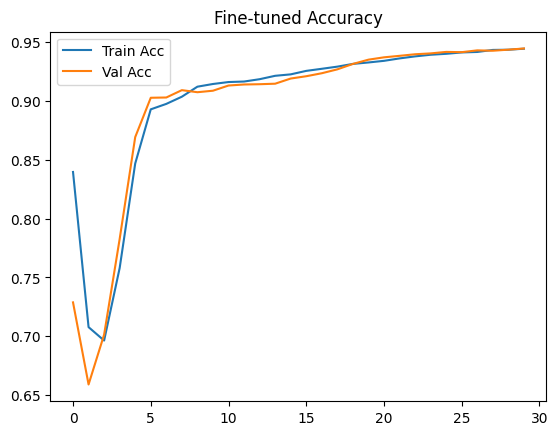

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=8,
    callbacks=[
        ModelCheckpoint('unet_1_finetuned4.h5', save_best_only=True),
        EarlyStopping(patience=5, restore_best_weights=True)
    ]
)
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Fine-tuned Accuracy")
plt.legend()
plt.show()


In [28]:
pred_probs = model.predict(X_val)

pred_classes = np.argmax(pred_probs, axis=-1)
true_classes = np.argmax(Y_val, axis=-1)

1/1 [==============================] - 1s 552ms/step


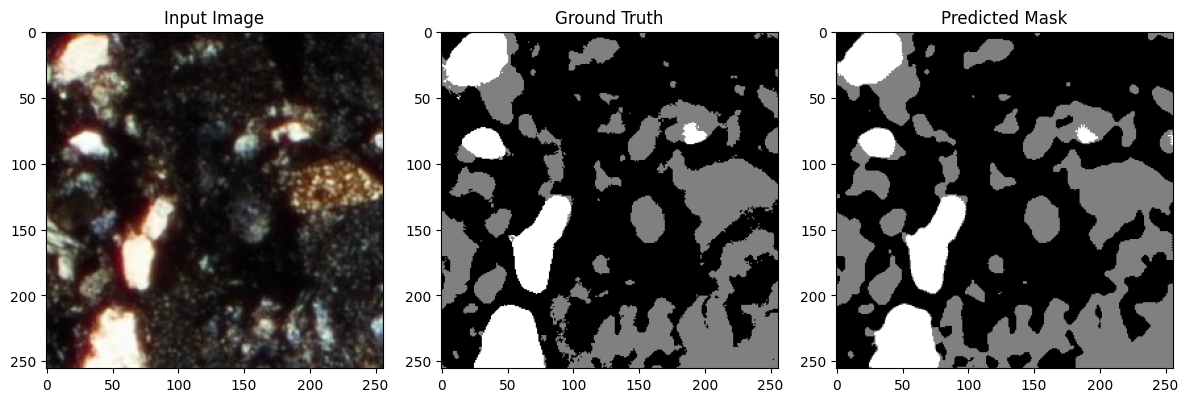

In [29]:
import matplotlib.pyplot as plt

i = 0  

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X_val[i])
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(true_classes[i], cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(pred_classes[i], cmap='gray')
plt.title("Predicted Mask")

plt.tight_layout()
plt.show()

## At the end of these trainings, model unet_finetuned4.h5 was obtained